In [1]:
!nvidia-smi

Sat Jul 25 14:10:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size=64

In [4]:
transform = transforms.Compose([
        transforms.ToTensor()])

In [5]:
#mnist data
train_dataset = torchvision.datasets.MNIST(root='data/mnist',
                                           train=True, 
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/mnist',
                                          train=False, 
                                          transform=transform)
#put into batches
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [6]:
class resblock(nn.Module):
  def __init__(self,n_channels):
    super(resblock,self).__init__()
    self.process = nn.Sequential(
                                 nn.Conv2d(in_channels=n_channels,out_channels=n_channels*2,kernel_size=3,stride=1,padding=1),
                                #  nn.BatchNorm2d(2*n_channels),
                                 nn.ReLU(),
                                 nn.Conv2d(in_channels=2*n_channels,out_channels=n_channels*4,kernel_size=3,stride=1,padding=1),
                                #  nn.BatchNorm2d(4*n_channels),
                                 nn.ReLU(),
                                 nn.Conv2d(in_channels=4*n_channels,out_channels=n_channels*4,kernel_size=3,stride=1,padding=1),
                                #  nn.BatchNorm2d(4*n_channels),
                                 nn.ReLU(),
                                 nn.Conv2d(in_channels=4*n_channels,out_channels=n_channels,kernel_size=3,stride=1,padding=1),
                                #  nn.BatchNorm2d(n_channels),
                                 nn.ReLU())
  def forward(self,x):
    return x+self.process(x)


In [7]:
class vae(nn.Module):
  def __init__(self):
    super(vae,self).__init__()
    self.base_encoder = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=4,kernel_size=3,stride=1,padding=1),
                                      resblock(4),
                                      nn.Conv2d(in_channels=4,out_channels=4,kernel_size=2,stride=2,padding=0),
                                      resblock(4),
                                      nn.Conv2d(in_channels=4,out_channels=1,kernel_size=3,stride=1,padding=1))
    self.y_encoder = nn.Sequential(nn.Linear(14*14,128),
                                   nn.ReLU(),
                                   nn.Linear(128,10))
    self.extraz = nn.Sequential(resblock(1),
                                nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2,stride=2,padding=0))
    self.extray = nn.Sequential(nn.Linear(10,32),nn.ReLU(),nn.Linear(32,49))
    self.final = resblock(1)
    self.zmu = nn.Linear(7*7,7*7)
    self.zvar = nn.Linear(7*7,7*7)

    self.ydec = nn.Sequential(nn.Linear(10,32),nn.ReLU(),nn.Linear(32,49))
    self.zdec = resblock(1)
    self.commondecoder = nn.Sequential(nn.ConvTranspose2d(2,2,kernel_size=2,stride=2,padding=0),
                                       nn.Conv2d(in_channels=2,out_channels=4,kernel_size=1,stride=1,padding=0),
                                       resblock(4),
                                       nn.ConvTranspose2d(4,4,kernel_size=2,stride=2,padding=0),
                                       resblock(4),
                                       nn.Conv2d(in_channels=4,out_channels=1,kernel_size=1,stride=1,padding=0),
                                       nn.Sigmoid())
  def encode(self,x):
    x = self.base_encoder(x)
    ylogit = self.y_encoder(x.reshape(x.shape[0],14*14))
    ysoft = F.softmax(ylogit, dim=1)
    _,preds  = torch.max(ysoft, 1)
    onehot = torch.eye(10).to(device) 
    onehot = onehot[preds]
    processed_onehot = self.extray(onehot.float())
    processed_onehot = processed_onehot.reshape(processed_onehot.shape[0],1,7,7)
    final = self.final(processed_onehot+self.extraz(x))
    zmu = self.zmu(final.reshape(final.shape[0],7*7))
    zvar = self.zvar(final.reshape(final.shape[0],7*7))
    return onehot,zmu,zvar,ysoft
  def forward(self,x):
    onehot,zmu,zvar,ysoft = self.encode(x)
    processed_onehot = self.ydec(onehot.float())
    processed_onehot = processed_onehot.reshape(processed_onehot.shape[0],1,7,7)
    std = zvar.mul(0.5).exp_()
    esp = torch.randn(*zmu.size()).to(device)
    z = zmu + std * esp
    processed_z = self.zdec(z.reshape(z.shape[0],1,7,7))
    recons = self.commondecoder(torch.cat((processed_onehot,processed_z),1))
    return recons,zmu,zvar,ysoft
  def loss(self,x,y):
    recons,zmu,zvar,ysoft = self.forward(x)
    catloss = nn.CrossEntropyLoss()(ysoft,y)
    reconsloss = nn.BCELoss()(recons,x)
    klloss = -0.5 * torch.sum(1 + zvar - zmu.pow(2) - zvar.exp())/x.shape[0]
    return catloss,reconsloss,klloss
  def generate_samples(self,labels,z):
    onehot = torch.eye(10).to(device) 
    onehot = onehot[labels]
    processed_onehot = self.ydec(onehot.float())
    processed_onehot = processed_onehot.reshape(processed_onehot.shape[0],1,7,7)
    processed_z = self.zdec(z.reshape(z.shape[0],1,7,7))
    recons = self.commondecoder(torch.cat((processed_onehot,processed_z),1))
    return recons




In [8]:
model = vae().to(device)

In [9]:
optim = torch.optim.Adam(model.parameters())

In [10]:
epochs=10

In [11]:
for epoch in range(1,epochs+1):
    minloss = 1
    running_kl_loss=0
    running_recons_loss=0
    running_cat_loss=0
    num_images=0
    for i,(img,label) in enumerate(train_loader):
      img = img.to(device)
      label=label.to(device)
      optim.zero_grad()
      cat_loss,recons_loss,kl_loss = model.loss(img,label)
      loss=recons_loss+0.1*cat_loss+epoch*0.001*kl_loss
      loss.backward()
      optim.step()
      running_cat_loss = running_cat_loss + cat_loss.item()*len(img)
      running_recons_loss = running_recons_loss + recons_loss.item()*len(img)
      running_kl_loss = running_kl_loss + kl_loss.item()*len(img)

      num_images= num_images+len(img)
    print('epoch: '+str(epoch)+' cat_loss: '+str(running_cat_loss/num_images)+' recons_loss: '+str(running_recons_loss/num_images)+' kl_loss: '+str(running_kl_loss/num_images))



epoch: 1 cat_loss: 1.5773502438227336 recons_loss: 0.1695886805256208 kl_loss: 27.154217933106423
epoch: 2 cat_loss: 1.5051887362162273 recons_loss: 0.12834858473936717 kl_loss: 21.104549123128255
epoch: 3 cat_loss: 1.4950193848292033 recons_loss: 0.13872360085646313 kl_loss: 14.539632057698567
epoch: 4 cat_loss: 1.4905989502588908 recons_loss: 0.1499377175807953 kl_loss: 10.550238130696615
epoch: 5 cat_loss: 1.4869295281092325 recons_loss: 0.16016118830045065 kl_loss: 7.858620559946696
epoch: 6 cat_loss: 1.4844559033075968 recons_loss: 0.16943557867209116 kl_loss: 5.887778346761068
epoch: 7 cat_loss: 1.4832855518341064 recons_loss: 0.17796976891358693 kl_loss: 4.435639974975586
epoch: 8 cat_loss: 1.4815393714904785 recons_loss: 0.18530817336241404 kl_loss: 3.360508731587728
epoch: 9 cat_loss: 1.4799657012939453 recons_loss: 0.19164855258464814 kl_loss: 2.538319591522217
epoch: 10 cat_loss: 1.4790660072962443 recons_loss: 0.19687359624703726 kl_loss: 1.9323876598993937


In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [13]:
recons,zmu,zvar,ysoft=0,0,0,0
for im,l in test_loader:
  recons,zmu,zvar,ysoft = model.forward(im.to(device))
  break

In [14]:
labels=[]
for i in range(10):
  for j in range(6):
    labels.append(i)

In [15]:
labels=torch.Tensor(np.array(labels)).long().to(device)

In [16]:
zl=[]
for i in range(10):
  e = torch.randn(6,7*7)
  std = zvar[:6].mul(0.5).exp_()
  z = zmu[:6].cpu().detach()+e*std.cpu().detach()
  zl.append(np.array(z))

In [17]:
zl=np.array(zl)

In [18]:
zl = torch.Tensor(zl.reshape(60,49)).to(device)

In [19]:
imgs = model.generate_samples(labels,zl).cpu().detach().reshape(60,28,28)

<Figure size 432x288 with 0 Axes>

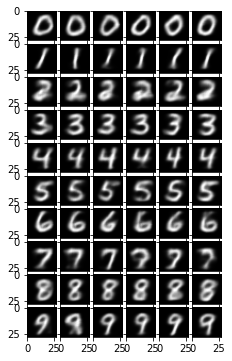

In [20]:
plt.gray()
fig = plt.figure(figsize=(10., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 6),  # creates 2x2 grid of axes
                 axes_pad=0.05  # pad between axes in inch.
                 )

for ax, im in zip(grid, imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()